# Part 4 - Neural Networks and Convolutional Neural Networks

### Importing necessary libraries and loading data


In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import os
import cv2

from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

Loading both the training and testing dataset:

In [3]:
CW_DATASET_PATH = "CW_dataset"



def load_data(dataset_path=CW_DATASET_PATH):
    x_train_all_path = os.path.join(dataset_path, "x_train_all.csv")
    y_train_all_path = os.path.join(dataset_path, "y_train_all.csv")
    x_test_all_path = os.path.join(dataset_path, "x_test_all.csv")
    y_test_all_path = os.path.join(dataset_path, "y_test_all.csv")

    x_train_all = pd.read_csv(x_train_all_path)
    y_train_all = pd.read_csv(y_train_all_path)
    x_test_all = pd.read_csv(x_test_all_path)
    y_test_all = pd.read_csv(y_test_all_path)

    return x_train_all, y_train_all,x_test_all,y_test_all

In [4]:
x_train, y_train,x_test, y_test = load_data()

In [5]:
x_train.shape


(9690, 2304)

In [6]:
y_train.shape


(9690, 1)

In [7]:
x_test.shape


(3090, 2304)

In [8]:
y_test.shape

(3090, 1)

In [ ]:
x_train = np.asarray(x_train)
x_train = x_train.reshape(x_train.shape[0], -1)
y_train = np.asarray(y_train).ravel()
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

## 1) Linear Classifier

In [ ]:
from sklearn.preprocessing import StandardScaler
# using solver sag, fast convergence is guaranteed with features with approximately the same scale

scaler = StandardScaler()

x_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

In [ ]:
from sklearn.linear_model import LogisticRegression
# for multi-class problems: lbfgs, sag, saga, newton-cg handle multinomial loss
log_reg = LogisticRegression(solver='saga', max_iter=5000, random_state=42)
log_reg.fit(x_scaled, y_train)

LogisticRegression(max_iter=5000, random_state=42, solver='saga')

### 10-fold Cross-Validation on train and test datasets

In [ ]:
from sklearn.model_selection import cross_val_score
cv_score = cross_val_score(log_reg, x_scaled, y_train, cv=10, scoring='accuracy')

print("Cross Validation scores:", cv_score)
print(f'Mean accuracy: {cv_score.mean()}')
print(f'Standard Deviation: {cv_score.std()}')

Cross Validation scores: [0.78018576 0.89680083 0.89164087 0.90092879 0.8875129  0.8998968
 0.85242518 0.88957688 0.89576883 0.92053664]
Mean accuracy: 0.8815273477812179
Standard Deviation: 0.03740539457797173


In [ ]:
cv_score_test = cross_val_score(log_reg, x_test_scaled, y_test, cv=10, scoring='accuracy')

print("Cross Validation scores:", cv_score_test)
print(f'Mean accuracy: {cv_score_test.mean()}')
print(f'Standard Deviation: {cv_score_test.std()}')

Cross Validation scores: [0.92880259 0.91585761 0.95469256 0.94174757 0.94498382 0.95469256
 0.95469256 0.96440129 0.95145631 0.9579288 ]
Mean accuracy: 0.946925566343042
Standard Deviation: 0.013972189737814172


### Accuracy on Train set

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = log_reg.predict(x_scaled)
accuracy = accuracy_score(y_train, y_pred)
print("accuracy without cv:", accuracy)

accuracy without cv: 0.9964912280701754


### Accuracy on Test set

In [ ]:
y_test_pred = log_reg.predict(x_test_scaled)

accuracy_test = accuracy_score(y_test, y_test_pred)
print(f"accuracy on test set:", {accuracy_test})

accuracy on test set: {0.8792880258899677}


## 2) Multilayer Perceptron (MLP)

### 2.1) Linear Perceptron

In [ ]:
from sklearn.linear_model import Perceptron

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(x_train, y_train)

predictions = per_clf.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_p = accuracy_score(y_test, predictions)
print('Accuracy for Linear Perceptron = ', accuracy_p)

Accuracy for Linear Perceptron =  0.8841423948220065


### 2.2) Multilayer Perceptron

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(100), activation='relu', max_iter=1000, random_state=42)
mlp.fit(x_train, y_train)

mlp_pred = mlp.predict(x_test)

In [ ]:
from sklearn.metrics import accuracy_score

accuracy_MLP = accuracy_score(y_test, mlp_pred)
print('Accuracy for Multilayer Perceptron = ', accuracy_MLP)

Accuracy for Multilayer Perceptron =  0.8009708737864077


#### 2.2.1) Experimenting with various neural network parameters

In [ ]:
# Solver : sgd
# Activation Functions: Logistic, ReLU, tanh
# Number & Size of Layers: (100, 50), (150, 100, 5), (50, 50, 50), (50, 40, 30, 20, 10)
# Learning Rate: constant, invscaling, adaptive
# Epochs: 200, 600, 1000
# Momentum: 0.49, 0.9
pd.set_option('display.max_colwidth', None)

def experiment_parameters_mlp(x_train, y_train, x_test, y_test):
    activ_funcs = ['logistic', 'relu', 'tanh']
    number_layers = [(100,50), (150,100,5), (50,50,50), (50,40,30,20,10)]
    learning_rate = ['constant', 'invscaling', 'adaptive'] 
    epochs = [200, 600, 1000] 
    momentum_val = [0.49, 0.9] 

    models = []

    for i in activ_funcs:
        for j in number_layers:
            for k in learning_rate:
                for l in epochs:
                    for m in momentum_val:
                        model = MLPClassifier (
                            #solver='sgd',
                            activation=i,
                            hidden_layer_sizes=j,
                            learning_rate=k,
                            max_iter=l,
                            momentum=m,
                            random_state=42
                        )
                        model.fit(x_train, y_train)
                        models.append(model)

    model_names = []
    accuracies = []
    for n in range(len(models)):
        model_pred = models[n].predict(x_test)
        model_accuracy = accuracy_score(y_test, model_pred)
        accuracies.append(model_accuracy)
        model_names.append(f'Model {n+1}')

    models_names_df = pd.DataFrame({'Model Name': model_names})
    models_df = pd.DataFrame({'Model': models})
    accuracy_df = pd.DataFrame({'Accuracy': accuracies})

    result_df = pd.concat([models_names_df, models_df, accuracy_df], axis=1)

    return result_df

In [ ]:
result = experiment_parameters_mlp(x_train, y_train, x_test, y_test)


In [ ]:
result

,Model Name,Model,Accuracy
0,Model 1,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n momentum=0.49, random_state=42)",0.242718
1,Model 2,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n random_state=42)",0.242718
2,Model 3,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50), max_iter=600,\n momentum=0.49, random_state=42)",0.242718
3,Model 4,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50), max_iter=600,\n random_state=42)",0.242718
4,Model 5,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n max_iter=1000, momentum=0.49, random_state=42)",0.242718
...,...,...,...
211,Model 212,"MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 40, 30, 20, 10),\n learning_rate='adaptive', random_state=42)",0.242718
212,Model 213,"MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 40, 30, 20, 10),\n learning_rate='adaptive', max_iter=600, momentum=0.49,\n random_state=42)",0.242718
213,Model 214,"MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 40, 30, 20, 10),\n learning_rate='adaptive', max_iter=600, random_state=42)",0.242718
214,Model 215,"MLPClassifier(activation='tanh', hidden_layer_sizes=(50, 40, 30, 20, 10),\n learning_rate='adaptive', max_iter=1000, momentum=0.49,\n random_state=42)",0.242718


In [ ]:
pd.set_option('display.max_rows', None)
result

,Model Name,Model,Accuracy
0,Model 1,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n momentum=0.49, random_state=42)",0.242718
1,Model 2,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n random_state=42)",0.242718
2,Model 3,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50), max_iter=600,\n momentum=0.49, random_state=42)",0.242718
3,Model 4,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50), max_iter=600,\n random_state=42)",0.242718
4,Model 5,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n max_iter=1000, momentum=0.49, random_state=42)",0.242718
5,Model 6,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n max_iter=1000, random_state=42)",0.242718
6,Model 7,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n learning_rate='invscaling', momentum=0.49, random_state=42)",0.242718
7,Model 8,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n learning_rate='invscaling', random_state=42)",0.242718
8,Model 9,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n learning_rate='invscaling', max_iter=600, momentum=0.49,\n random_state=42)",0.242718
9,Model 10,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n learning_rate='invscaling', max_iter=600, random_state=42)",0.242718


In [ ]:
def calculate_train_test_acc(x_train, y_train):
    accuracies = []
    for n in range(len(result)):
        model_pred = result["Model"][n].predict(x_train)
        model_accuracy = accuracy_score(y_train, model_pred)
        accuracies.append(model_accuracy)

    accuracy_df = pd.DataFrame({'Training Accuracy': accuracies})
    test_acc_df = pd.DataFrame({'Testing Accuracy' : result["Accuracy"]})

    result_df = pd.concat([result["Model Name"], result["Model"], accuracy_df, test_acc_df], axis=1)

    return result_df

In [ ]:
final_df = calculate_train_test_acc(x_train, y_train)
final_df

,Model Name,Model,Training Accuracy,Testing Accuracy
0,Model 1,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n momentum=0.49, random_state=42)",0.232198,0.242718
1,Model 2,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n random_state=42)",0.232198,0.242718
2,Model 3,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50), max_iter=600,\n momentum=0.49, random_state=42)",0.232198,0.242718
3,Model 4,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50), max_iter=600,\n random_state=42)",0.232198,0.242718
4,Model 5,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n max_iter=1000, momentum=0.49, random_state=42)",0.232198,0.242718
5,Model 6,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n max_iter=1000, random_state=42)",0.232198,0.242718
6,Model 7,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n learning_rate='invscaling', momentum=0.49, random_state=42)",0.232198,0.242718
7,Model 8,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n learning_rate='invscaling', random_state=42)",0.232198,0.242718
8,Model 9,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n learning_rate='invscaling', max_iter=600, momentum=0.49,\n random_state=42)",0.232198,0.242718
9,Model 10,"MLPClassifier(activation='logistic', hidden_layer_sizes=(100, 50),\n learning_rate='invscaling', max_iter=600, random_state=42)",0.232198,0.242718


In [ ]:
#
max_acc = result["Accuracy"].max()
print("Maximum Accuracy = ", max_acc)

max_acc_df = result[result["Accuracy"] == max_acc].copy()

print(f"Total Number of Models with {max_acc} accuracy = ", len(max_acc_df))
max_acc_df

Maximum Accuracy =  0.8838187702265372
Total Number of Models with 0.8838187702265372 accuracy =  18


,Model Name,Model,Accuracy
108,Model 109,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), momentum=0.49, random_state=42)",0.883819
109,Model 110,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), random_state=42)",0.883819
110,Model 111,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=600, momentum=0.49,\n random_state=42)",0.883819
111,Model 112,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=600, random_state=42)",0.883819
112,Model 113,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=1000, momentum=0.49,\n random_state=42)",0.883819
113,Model 114,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=1000, random_state=42)",0.883819
114,Model 115,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='invscaling',\n momentum=0.49, random_state=42)",0.883819
115,Model 116,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='invscaling',\n random_state=42)",0.883819
116,Model 117,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='invscaling',\n max_iter=600, momentum=0.49, random_state=42)",0.883819
117,Model 118,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='invscaling',\n max_iter=600, random_state=42)",0.883819


##### Using Cross-Validation:

In [ ]:
from sklearn.model_selection import cross_val_score

y_test = y_test.ravel()
cross_val = []

for i in range(len(max_acc_df)):
    model = max_acc_df.iloc[i]["Model"]
    scores = cross_val_score(model, x_train, y_train, scoring="accuracy", cv=10)
    cross_val.append(scores.mean())

cross_val_df = pd.DataFrame({"Cross Validation Score" : cross_val})
max_acc_df = max_acc_df.reset_index(drop=True)

cv_df = pd.concat([max_acc_df, cross_val_df], axis=1)
cv_df


,Model Name,Model,Accuracy,Cross Validation Score
0,Model 109,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), momentum=0.49, random_state=42)",0.883819,0.849742
1,Model 110,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), random_state=42)",0.883819,0.849742
2,Model 111,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=600, momentum=0.49,\n random_state=42)",0.883819,0.849742
3,Model 112,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=600, random_state=42)",0.883819,0.849742
4,Model 113,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=1000, momentum=0.49,\n random_state=42)",0.883819,0.849742
5,Model 114,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), max_iter=1000, random_state=42)",0.883819,0.849742
6,Model 115,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='invscaling',\n momentum=0.49, random_state=42)",0.883819,0.849742
7,Model 116,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='invscaling',\n random_state=42)",0.883819,0.849742
8,Model 117,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='invscaling',\n max_iter=600, momentum=0.49, random_state=42)",0.883819,0.849742
9,Model 118,"MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='invscaling',\n max_iter=600, random_state=42)",0.883819,0.849742


##### Using Grid Search CV:

In [ ]:
from sklearn.model_selection import GridSearchCV

mlp_grid = MLPClassifier()

param_grid = {
    'activation' : ['logistic', 'relu', 'tanh'],
    'hidden_layer_sizes' : [(100,50), (150,100,5), (50,50,50), (50,40,30,20,10)],
    'learning_rate' : ['constant', 'invscaling', 'adaptive'],
    'max_iter' : [200, 600, 1000],
    'momentum' : [0.49, 0.9]
}

gs = GridSearchCV(mlp_grid, param_grid, scoring='accuracy', cv=10, n_jobs=-1)

gs.fit(x_train, y_train)

best_params = gs.best_params_
print("Best parameters: ", best_params)
best_model = gs.best_estimator_
print("Best model: ", best_model)

gs_pred = best_model.predict(x_test)
accuracy_gs = accuracy_score(y_test, gs_pred)
print(f"Accuracy on Test Set: {accuracy_gs:.4f}")

Best parameters:  {'activation': 'relu', 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'invscaling', 'max_iter': 1000, 'momentum': 0.49}
Best model:  MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='invscaling',max_iter=1000, momentum=0.49)
Accuracy on Test Set: 0.8773


### Exploring the best model found

#### Finding accuracy :

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_best_model = MLPClassifier(hidden_layer_sizes=(50,50,50), activation='relu', max_iter=1000, learning_rate='invscaling',momentum=0.49)
mlp_best_model.fit(x_train, y_train)

mlp_pred_test= mlp_best_model.predict(x_test)

from sklearn.metrics import accuracy_score

accuracy_best_mlp_model_test = accuracy_score(y_test, mlp_pred_test)
print('Test accuracy for best mlp found = ', accuracy_best_mlp_model_test)

mlp_pred_train = mlp_best_model.predict(x_train)
accuracy_best_mlp_model_train = accuracy_score(y_train, mlp_pred_train)
print('Training accuracy for the best MLP model found = ', accuracy_best_mlp_model_train)

Test accuracy for best mlp found =  0.8352750809061489
Training accuracy for the best MLP model found =  0.910423116615067


##### Confusion Matrix for the best model

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

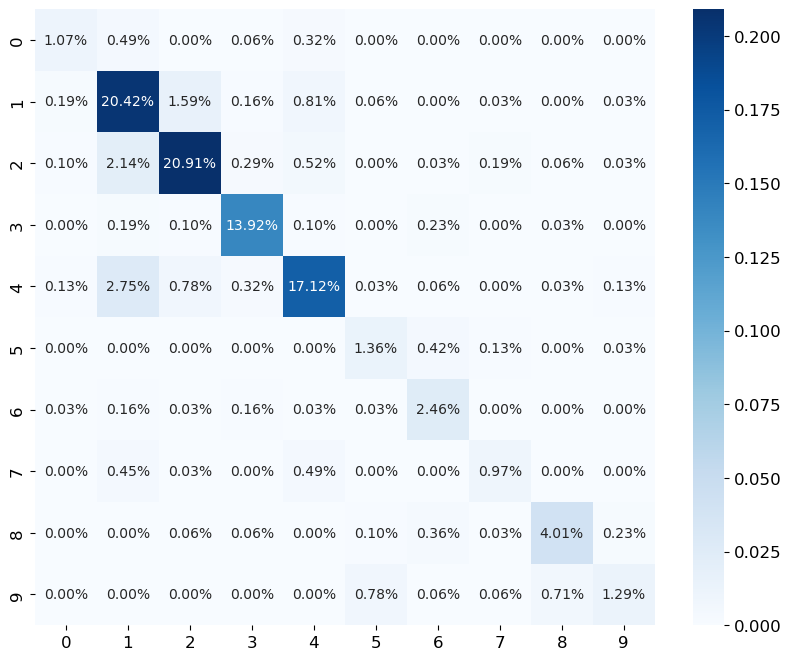

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix_train = confusion_matrix(y_test,mlp_pred_test )
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_train/np.sum(confusion_matrix_train), annot=True,  fmt='.2%', cmap='Blues')
plt.tight_layout

#### Different activation functions

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split

activations = ['logistic', 'relu', 'tanh']
test_accuracies = []
train_accuracies = []
cross_val_accuracies = []

for activation in activations:
    mlp_model = MLPClassifier(hidden_layer_sizes=(50, 50, 50), activation=activation, max_iter=1000, learning_rate='invscaling', momentum=0.49)
    mlp_model.fit(x_train, y_train)

    test_accuracy = mlp_model.score(x_test, y_test)
    train_accuracy = mlp_model.score(x_train, y_train)
    cross_val_accuracy = np.mean(cross_val_score(mlp_model, x_train, y_train,scoring="accuracy", cv=10))

    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)
    cross_val_accuracies.append(cross_val_accuracy)

In [ ]:
print("train accuracy list :", train_accuracies)
print("test accuracy list :",test_accuracies)
print("cross-val accuracy list :",cross_val_accuracies )

train accuracy list : [0.23219814241486067, 0.8168214654282766, 0.23364293085655316]
test accuracy list : [0.24271844660194175, 0.7728155339805826, 0.24271844660194175]
cross-val accuracy list : [0.22786377708978328, 0.7545923632610939, 0.23457172342621257]


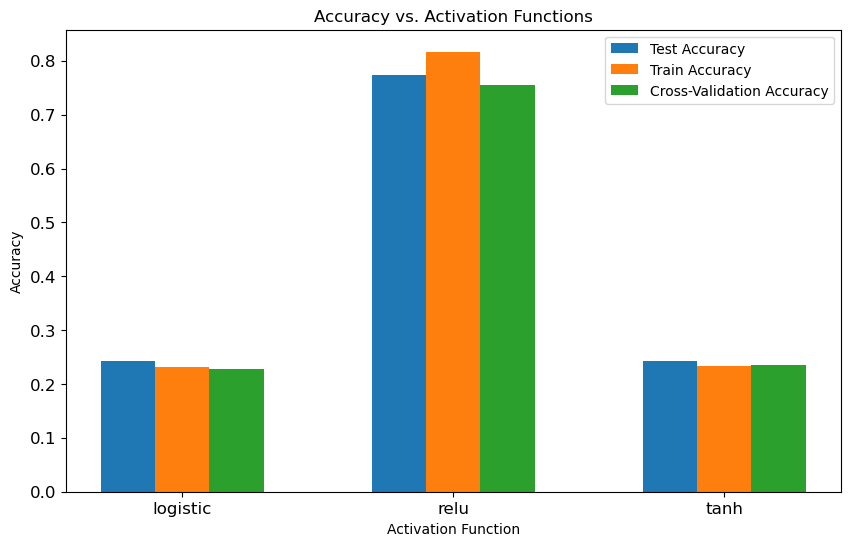

In [ ]:
# Plot the bar graph
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = np.arange(len(activations))

rects1 = ax.bar(index, test_accuracies, bar_width, label='Test Accuracy')
rects2 = ax.bar(index + bar_width, train_accuracies, bar_width, label='Train Accuracy')
rects3 = ax.bar(index + 2*bar_width, cross_val_accuracies, bar_width, label='Cross-Validation Accuracy')

ax.set_xlabel('Activation Function')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs. Activation Functions')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(activations)
ax.legend()

plt.show()

#### Different Momentum

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPClassifier
import numpy as np

momentum_values = np.linspace(0,1,10)
momentum_test_accuracies = []

for momentum in momentum_values:
    mlp_model = MLPClassifier(hidden_layer_sizes=(50, 50, 50), activation='relu', max_iter=1000, learning_rate='invscaling', momentum=momentum)
    mlp_model.fit(x_train, y_train)

    test_accuracy = mlp_model.score(x_test, y_test)

    momentum_test_accuracies.append(test_accuracy)

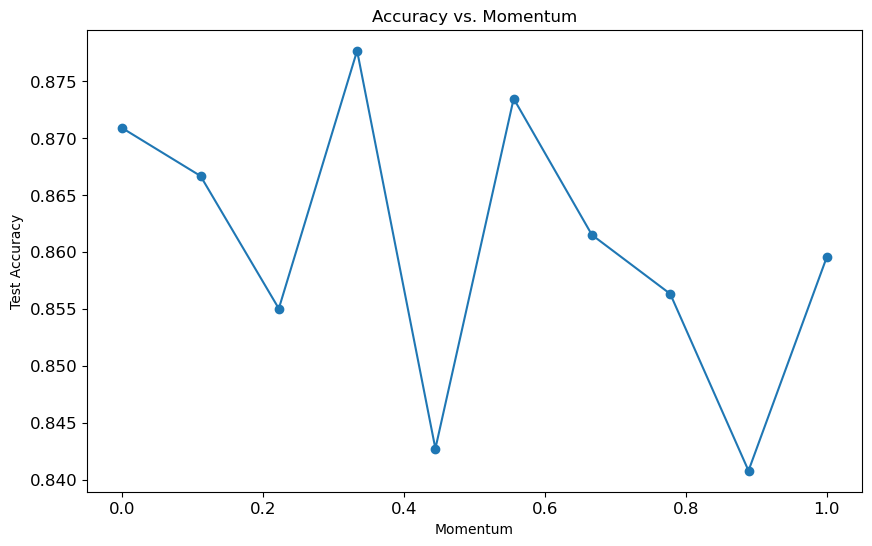

In [ ]:

plt.figure(figsize=(10, 6))
plt.plot(momentum_values, momentum_test_accuracies, marker='o')
plt.title('Accuracy vs. Momentum')
plt.xlabel('Momentum')
plt.ylabel('Test Accuracy')
plt.show()


#### Different Learning Rates

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score, train_test_split

learningRate = ['invscaling', 'adaptive', 'constant']
learningRate_test_accuracies = []
learningRate_train_accuracies = []
learningRate_cross_val_accuracies = []

for learning_rate in learningRate:
    mlp_model = MLPClassifier(hidden_layer_sizes=(50, 50, 50), activation='relu', max_iter=1000, learning_rate=learning_rate, momentum=0.49)
    mlp_model.fit(x_train, y_train)

    learningRate_test_accuracy = mlp_model.score(x_test, y_test)
    learningRate_train_accuracy = mlp_model.score(x_train, y_train)
    learningRate_cross_val_accuracy = np.mean(cross_val_score(mlp_model, x_train, y_train,scoring="accuracy", cv=10))

    learningRate_train_accuracies.append(learningRate_train_accuracy)
    learningRate_cross_val_accuracies.append(learningRate_cross_val_accuracy)
    learningRate_test_accuracies.append(learningRate_test_accuracy)

In [ ]:
print("train accuracy list :", learningRate_train_accuracies)
print("test accuracy list :",learningRate_test_accuracies)
print("cross-val accuracy list :",learningRate_cross_val_accuracies )

train accuracy list : [0.9678018575851394, 0.9641898864809082, 0.9777089783281734]
test accuracy list : [0.8938511326860842, 0.8883495145631068, 0.8961165048543689]
cross-val accuracy list : [0.7549019607843137, 0.6917440660474716, 0.7432404540763673]


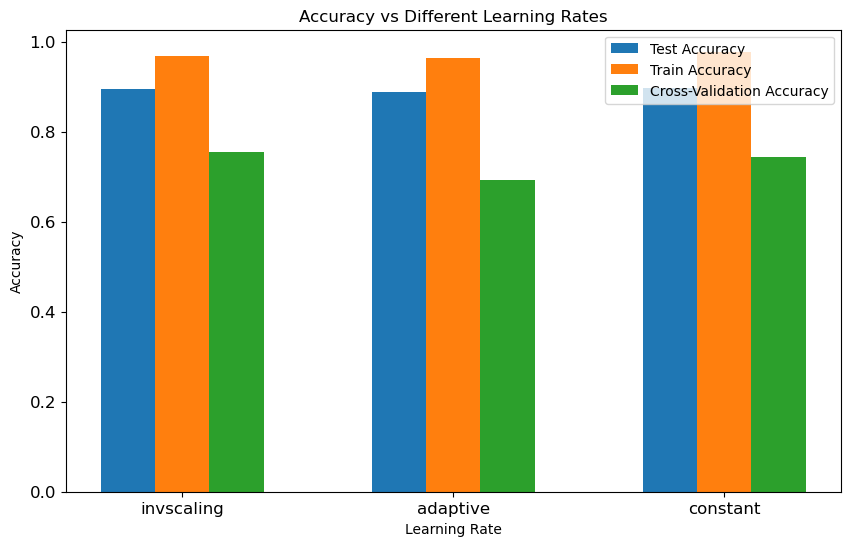

In [ ]:

fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = np.arange(len(learningRate))

rects1 = ax.bar(index, learningRate_test_accuracies, bar_width, label='Test Accuracy')
rects2 = ax.bar(index + bar_width, learningRate_train_accuracies, bar_width, label='Train Accuracy')
rects3 = ax.bar(index + 2*bar_width, learningRate_cross_val_accuracies, bar_width, label='Cross-Validation Accuracy')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs Different Learning Rates')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(learningRate)
ax.legend(loc="upper right")

plt.show()

#### Visualization of predicted class probabilities

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# function used to predict the probability the image can belong to various classes
def visualize_prediction(image_index, x_train, y_train, mlp_model):

    plt.figure(figsize=(10, 6))

    img = x_train[image_index]
    true_label = y_train[image_index]

    img = img.reshape((48, 48)) #incase not in correct format
    predicted_classes = mlp_model.predict_proba(img.reshape(1, -1))[0]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 4))

    # Shoow image
    ax1.imshow(img)
    ax1.set_title(f'True Label: {true_label}')

    # Graph prediction
    classes = np.arange(len(predicted_classes))
    ax2.bar(classes, predicted_classes, color='#4a7ba6')
    ax2.set_title('Prediction')
    ax2.set_xlabel('Class')
    ax2.set_ylabel('Probability')
    ax2.set_xticks(classes)
    ax2.set_xticklabels([f'Class {i}' for i in classes])
    plt.tight_layout
    plt.show()

<Figure size 1000x600 with 0 Axes>

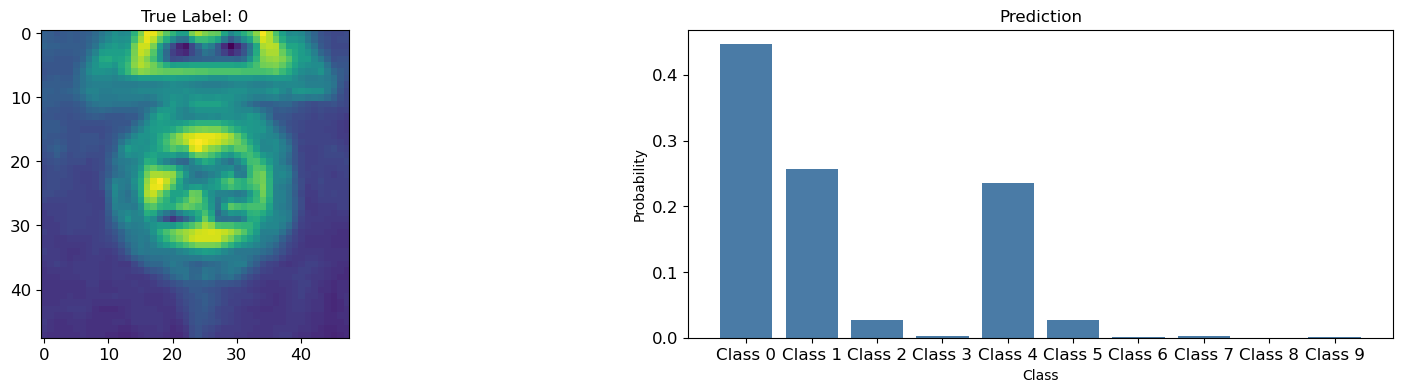

In [ ]:
visualize_prediction(150, x_train, y_train, mlp_best_model)

### Generalization and Overfitting analysis

####  Making new training and test datasets by moving 30% train dataset to test dataset


In [ ]:
# Here, we split the training dataset and combine the 30% of test split with the original test dataset.
from sklearn.model_selection import train_test_split

seed_value = 24

x_train_split_30, x_test_split_30, y_train_split_30, y_test_split_30 = train_test_split(x_train, y_train, test_size=0.3, random_state=seed_value)

x_test_30 = np.vstack((x_test, x_test_split_30))

if len(y_test.shape) != len(y_test_split_30.shape):
    if len(y_test.shape) > len(y_test_split_30.shape):
        y_test_split_30 = y_test_split_30.reshape(-1, 1)
    else:
        y_test = y_test.reshape(-1, 1)

y_test_30 = np.concatenate((y_test, y_test_split_30))

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_best_model_30 = MLPClassifier(hidden_layer_sizes=(50,50,50), activation='relu', max_iter=1000, learning_rate='invscaling',momentum=0.49)
mlp_best_model_30.fit(x_train_split_30, y_train_split_30 )

mlp_pred_test_train_30 = mlp_best_model.predict(x_train_split_30)
train_accuracy_30 = accuracy_score(y_train_split_30, mlp_pred_test_train_30)
print('Accuracy on training set = ', train_accuracy_30)

mlp_pred_test_test_30 = mlp_best_model.predict(x_test_30)
test_accuracy_30 = accuracy_score(y_test_30,mlp_pred_test_test_30 )
print('Accuracy on test set= ', test_accuracy_30)


Accuracy on training set =  0.9088898717381689
Accuracy on test set=  0.8734367183591796


In [ ]:
from sklearn.metrics import classification_report

class_rep_30_ndt = classification_report(y_test_30, mlp_pred_test_test_30, zero_division=1)
print('Classification Report (test set) ')
print(class_rep_30_ndt)

Classification Report (test set) 
              precision    recall  f1-score   support

           0       0.80      0.70      0.75       123
           1       0.81      0.91      0.86      1387
           2       0.91      0.88      0.90      1431
           3       0.93      0.95      0.94       878
           4       0.92      0.86      0.89      1263
           5       0.62      0.76      0.68       110
           6       0.77      0.86      0.81       203
           7       0.83      0.75      0.79       133
           8       0.89      0.87      0.88       314
           9       0.79      0.52      0.62       155

    accuracy                           0.87      5997
   macro avg       0.83      0.81      0.81      5997
weighted avg       0.88      0.87      0.87      5997



#### Making new training and test datasets by moving 60% train dataset to test dataset


In [ ]:
# Here, we split the training dataset and combine the 60% of test split with the original test dataset.
x_train_split_60, x_test_split_60, y_train_split_60, y_test_split_60 = train_test_split(x_train, y_train, test_size=0.6, random_state=seed_value)

x_test_60 = np.vstack((x_test, x_test_split_60))

if len(y_test.shape) != len(y_test_split_60.shape):
    if len(y_test.shape) > len(y_test_split_60.shape):
        y_test_split_60 = y_test_split_60.reshape(-1, 1)
    else:
        y_test = y_test.reshape(-1, 1)

y_test_60 = np.concatenate((y_test, y_test_split_60))

In [ ]:
from sklearn.neural_network import MLPClassifier

mlp_best_model_60 = MLPClassifier(hidden_layer_sizes=(50,50,50), activation='relu', max_iter=1000, learning_rate='invscaling',momentum=0.49)
mlp_best_model_60.fit(x_train_split_60, y_train_split_60 )

mlp_pred_test_train_60 = mlp_best_model.predict(x_train_split_60)
train_accuracy_60 = accuracy_score(y_train_split_60, mlp_pred_test_train_60)
print('Accuracy on training set = ', train_accuracy_60)

mlp_pred_test_test_60 = mlp_best_model.predict(x_test_60)
test_accuracy_60 = accuracy_score(y_test_60, mlp_pred_test_test_60)
print('Accuracy on test set = ', test_accuracy_60)

Accuracy on training set =  0.9055727554179567
Accuracy on test set =  0.886455525606469


In [ ]:
class_rep_60 = classification_report(y_test_60,mlp_pred_test_test_60 , zero_division=1)
print('Classification Report (test set)  ')
print(class_rep_60)

Classification Report (test set)  
              precision    recall  f1-score   support

           0       0.79      0.75      0.77       175
           1       0.83      0.92      0.87      2057
           2       0.92      0.88      0.90      2120
           3       0.94      0.95      0.95      1303
           4       0.94      0.88      0.91      1859
           5       0.65      0.77      0.71       180
           6       0.81      0.87      0.84       297
           7       0.83      0.83      0.83       194
           8       0.90      0.90      0.90       475
           9       0.85      0.55      0.67       244

    accuracy                           0.89      8904
   macro avg       0.85      0.83      0.83      8904
weighted avg       0.89      0.89      0.89      8904



A small degree of overfitting is present as accuracy increases with increased images of training set in test set.


## 3) Convolutional Neural Networks (CNN)

In [ ]:
x_train_normalized, x_test_normalized=np.array(x_train)/255, np.array(x_test)/255
x_train_reshaped = x_train_normalized.reshape((x_train_normalized.shape[0], 48, 48, 1))
x_test_reshaped = x_test_normalized.reshape((x_test_normalized.shape[0], 48, 48, 1))

In [20]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, recall_score, accuracy_score,roc_auc_score
from sklearn.model_selection import cross_val_score,cross_val_predict
from sklearn.metrics import roc_curve, auc

def calculate_metrics_and_mean(X_train, y_train, y_pred, model):
    report = classification_report(y_train, y_pred, output_dict=True,zero_division=0)
    report_df = pd.DataFrame(report).T.iloc[:-3].drop(columns='support')
    cm = confusion_matrix(y_train, y_pred)
    tp = np.diagonal(cm)
    fn = np.sum(cm, axis=1) - tp
    fp = np.sum(cm, axis=0) - tp
    tn = np.sum(cm) - (tp + fn + fp)
    tp_rate = tp / (tp + fn)
    fp_rate = fp / (fp + tn)
    tp_fp_rate_df = pd.DataFrame({'TPR': tp_rate, 'FPR': fp_rate}, index=range(len(tp_rate)))
    specificity = []
    unique_labels = np.unique(y_train)
    try:
        for i in range(len(unique_labels)):
            true_negative = np.sum(cm) - np.sum(cm[i, :]) - np.sum(cm[:, i]) + cm[i, i]
            total_negative = np.sum(cm) - np.sum(cm[i, :])
            specificity.append(true_negative / total_negative)
        specificity_df = pd.DataFrame({'specificity': specificity}, index=unique_labels)
    except:
        specificity_df = pd.DataFrame({'specificity': np.nan}, index=unique_labels)
    try:
        sensitivity = recall_score(y_train, y_pred, average=None)
        sensitivity_df = pd.DataFrame({'sensitivity': sensitivity}, index=unique_labels)
    except:
        sensitivity_df = pd.DataFrame({'sensitivity': np.nan}, index=unique_labels)

    result_df = pd.concat([report_df.reset_index().drop(columns='index'),
                           tp_fp_rate_df.reset_index().drop(columns='index'),
                           specificity_df.reset_index().drop(columns='index'),
                           sensitivity_df.reset_index().drop(columns='index')], axis=1)

    try:
        probabilities=model.predict_proba(X_train)
        aucs= []
        for i in range(len(unique_labels)):
            fpr_dt, tpr_dt, _ = roc_curve((y_test == unique_labels[i]).astype(int), probabilities[:, i])
            roc_auc_dt = auc(fpr_dt, tpr_dt)
            aucs.append(roc_auc_dt)
    except:
        aucs = 0
    auc_df = pd.DataFrame({'AUC': aucs}, index=unique_labels)

    accuracy = accuracy_score(y_train, y_pred)
    accuracy_df = pd.DataFrame({'accuracy': [accuracy]})

    try:
        cross_val_scores = cross_val_score(model, X_train, y_train, cv=10)
    except :
        try:
            cross_val_scores = cross_val_predict(model, X_train, y_train, cv=10)
        except:
            cross_val_scores = [0]

    cross_val_mean = np.mean(cross_val_scores)
    cross_val_std = np.std(cross_val_scores)
    cross_val_df = pd.DataFrame({'CV mean': [cross_val_mean], 'CV std': [cross_val_std]})

    result_df = pd.concat([result_df, auc_df, accuracy_df, cross_val_df], axis=1)
    mean_values = pd.DataFrame(result_df.mean()).transpose()
    mean_values.index = ['mean']
    result_df = pd.concat([result_df, mean_values])

    return result_df

References:
<br/> 1. https://www.tensorflow.org/tutorials/images/cnn
<br/> 2. https://colab.research.google.com/drive/1uWZQ-lzAk5308YVjMW5XaZcS_3zmGSgN?usp=sharing

In [ ]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn(input_shape=input_shape, num_classes=10, dense_units=64, learning_rate=0.001, loss='sparse_categorical_crossentropy',
               kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    # pooling input layer
    model.add(layers.MaxPooling2D((2, 2)))
    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [ ]:
def plotHistory(history):
    plt.plot(history.history['accuracy'], label='accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, 1])
    plt.legend(loc='lower right')

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score
import pandas as pd

results_df=pd.DataFrame()

def cross_validate_and_evaluate(x_train, y_train, x_test, y_test,
                                 model,name='Model', epochs=10, batch_size=64):
    history = model.fit(x_train, y_train, epochs=epochs,
                         batch_size=batch_size, validation_data=(x_test_reshaped, y_test), verbose=0)

    n_splits = 10
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    test_accuracy = accuracy_score(model.predict(x_test), y_test)
    train_accuracy = accuracy_score(model.predict(x_train), y_train)
    cv_accuracy = cross_val_score(model, x_train, y_train, cv=kf, scoring='accuracy', verbose=0).mean()

    results_dict = {'Model': name,
                    'CV10_Mean_Accuracy': cv_accuracy,
                    'Train_accuracy': train_accuracy,
                    'Test_accuracy': test_accuracy,
                    }
    global results_df
    results_df = pd.concat([results_df, pd.DataFrame([results_dict])], ignore_index=True)
    return results_dict, history


In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
num_classes=10
epochs=10
batch_size=64
kernel=(3, 3)
strides=(2, 2)
input_shape=x_train_reshaped.shape[1:]

C:\Users\Poornima\AppData\Local\Temp\ipykernel_6376\270069022.py:9: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,


31/31 [==============================] - 0s 4ms/step


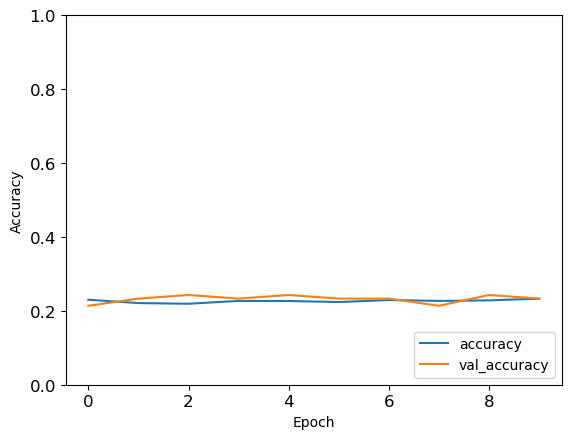

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier

num_classes=10
epochs=10
batch_size=64
kernel=(3, 3)
strides=(2, 2)
input_shape=x_train_reshaped.shape[1:]
model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.1)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                    'M1 LR 0.1',epochs,batch_size)
plotHistory(history)

C:\Users\Poornima\AppData\Local\Temp\ipykernel_6376\2504390988.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,


31/31 [==============================] - 0s 4ms/step


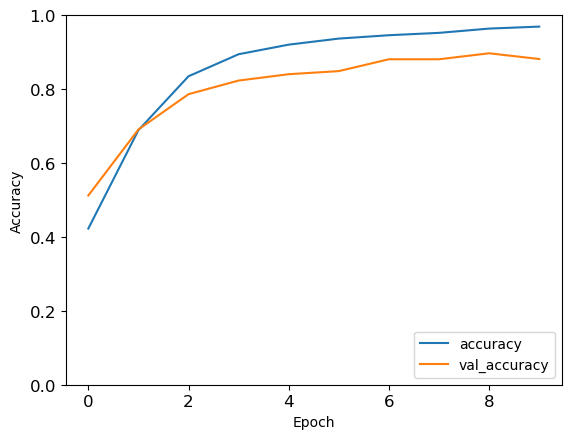

In [ ]:
model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                    'M1 LR 0.001',epochs,batch_size)
plotHistory(history)

C:\Users\Poornima\AppData\Local\Temp\ipykernel_6376\3111095439.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,


31/31 [==============================] - 0s 5ms/step


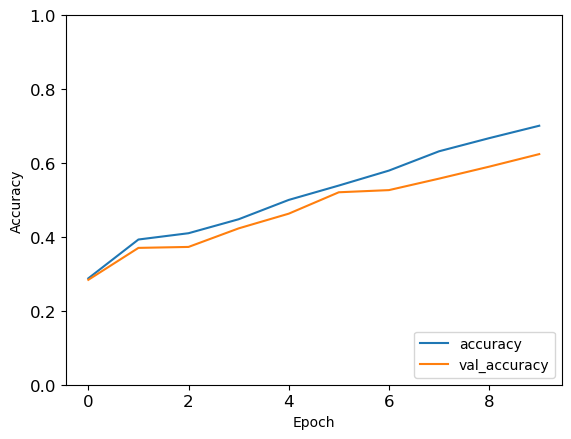

In [ ]:
model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,
                        num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.0001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                    'M1 LR 0.0001',epochs,batch_size)
plotHistory(history)

C:\Users\Poornima\AppData\Local\Temp\ipykernel_6376\283570719.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,


31/31 [==============================] - 0s 5ms/step


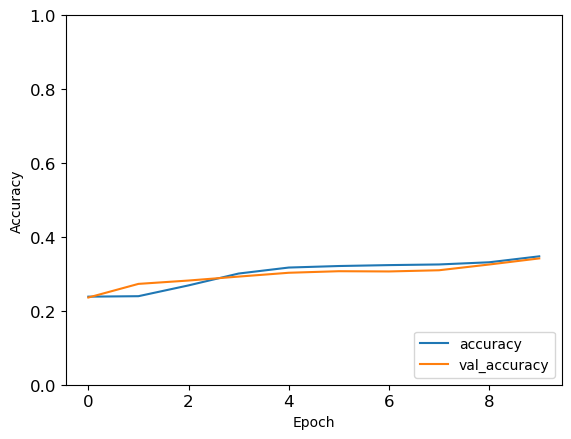

In [ ]:
model = KerasClassifier(build_fn=create_cnn, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,kernel=kernel,learning_rate=0.00001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                  'M1 LR 0.00001',epochs,batch_size)
plotHistory(history)

In [ ]:
results_df

,Model,CV10_Mean_Accuracy,Train_accuracy,Test_accuracy
0,M1 LR 0.1,0.231785,0.229102,0.233010
1,M1 LR 0.001,0.597214,0.963364,0.881230
2,M1 LR 0.0001,0.388958,0.728483,0.623948
3,M1 LR 0.00001,0.256863,0.351909,0.341748


In [ ]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn_ex(input_shape=input_shape, num_classes=10, dense_units=64,
                   learning_rate=0.001, loss='sparse_categorical_crossentropy',
                    kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))
    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


C:\Users\Poornima\AppData\Local\Temp\ipykernel_6376\486445807.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex, input_shape=input_shape,


31/31 [==============================] - 0s 5ms/step


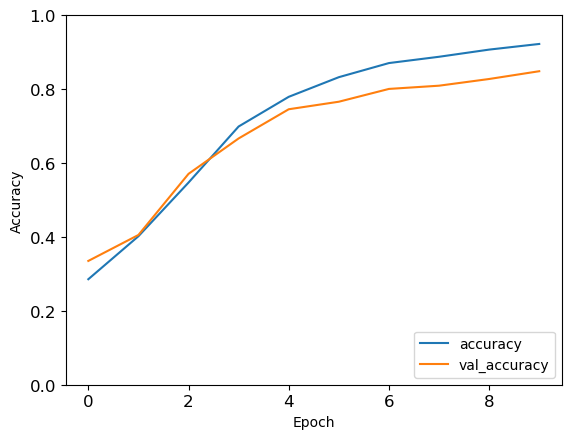

In [ ]:
# best LR so far 0.001

model = KerasClassifier(build_fn=create_cnn_ex, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,
                         kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                  'M2 LR 0.001',epochs,batch_size)
plotHistory(history)

In [ ]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn_ex2(input_shape=input_shape, num_classes=10, dense_units=64,
                    learning_rate=0.001, loss='sparse_categorical_crossentropy',
                    kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))

    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

C:\Users\Poornima\AppData\Local\Temp\ipykernel_6376\2738745057.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, input_shape=input_shape,


31/31 [==============================] - 0s 4ms/step


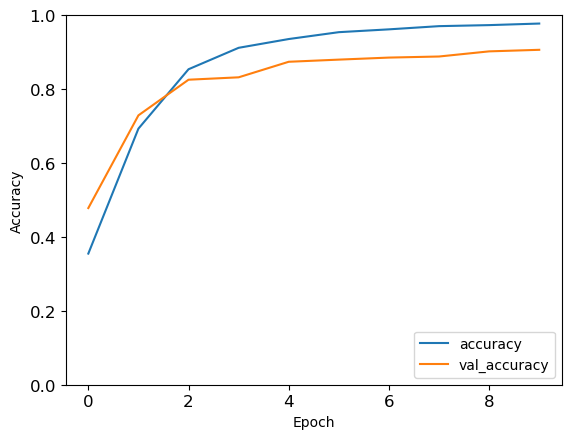

In [ ]:
# best LR so far 0.001
model = KerasClassifier(build_fn=create_cnn_ex2, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,
                         kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                  'M3 LR 0.001 softmax',epochs,batch_size)
plotHistory(history)

Reference: https://adriangb.com/scikeras/stable/generated/scikeras.wrappers.KerasClassifier.html#scikeras.wrappers.KerasClassifier


#### Trying different activation fuctions on the output layer

In [ ]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn_ex3(input_shape=input_shape, num_classes=10, dense_units=64,
                    learning_rate=0.001, loss='sparse_categorical_crossentropy',
                    kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))

    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='sigmoid'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


C:\Users\Poornima\AppData\Local\Temp\ipykernel_6376\2434522372.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex3, input_shape=input_shape,


31/31 [==============================] - 0s 4ms/step


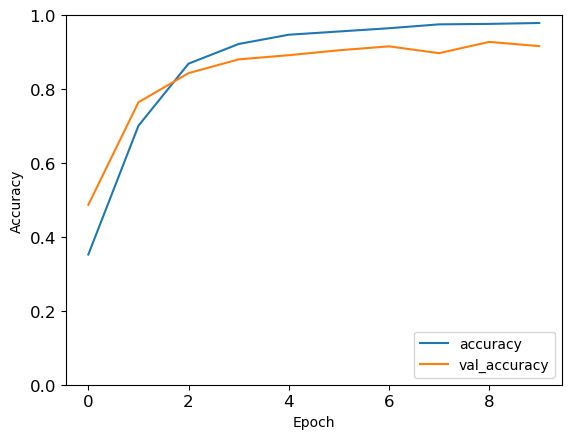

In [ ]:
# best LR so far 0.001
model = KerasClassifier(build_fn=create_cnn_ex3, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,
                         kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                  'M3 LR 0.001 sigmoid',epochs,batch_size)
plotHistory(history)

In [ ]:
import tensorflow as tf
from tensorflow.keras import  layers, models
import matplotlib.pyplot as plt
input_shape = x_train_reshaped.shape[1:]

def create_cnn_ex4(input_shape=input_shape, num_classes=10, dense_units=64,
                    learning_rate=0.001, loss='sparse_categorical_crossentropy',
                    kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))

    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='linear'))  #basically no activation functon as it has no effect on the weights
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


C:\Users\Poornima\AppData\Local\Temp\ipykernel_6376\2709864942.py:3: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex4, input_shape=input_shape,


31/31 [==============================] - 0s 4ms/step


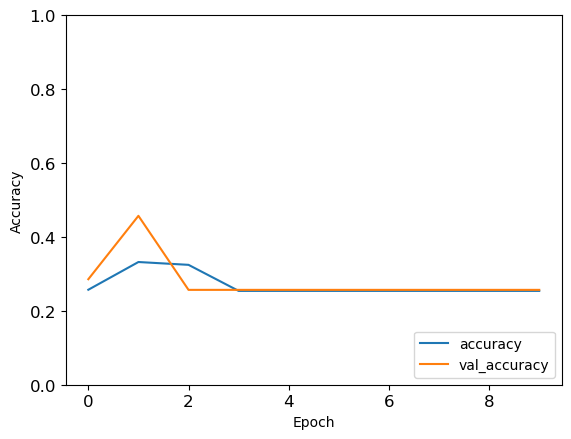

In [ ]:
# best LR so far 0.001

model = KerasClassifier(build_fn=create_cnn_ex4, input_shape=input_shape,
                         num_classes=num_classes,strides=strides,
                         kernel=kernel,learning_rate=0.001)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                  'M3 LR 0.001 linear',epochs,batch_size)
plotHistory(history)

In [ ]:
results_df

,Model,CV10_Mean_Accuracy,Train_accuracy,Test_accuracy
0,M1 LR 0.1,0.231785,0.229102,0.233010
1,M1 LR 0.001,0.597214,0.963364,0.881230
2,M1 LR 0.0001,0.388958,0.728483,0.623948
3,M1 LR 0.00001,0.256863,0.351909,0.341748
4,M2 LR 0.001,0.378328,0.934469,0.848220
5,M3 LR 0.001 softmax,0.625077,0.986275,0.906149
6,M3 LR 0.001 sigmoid,0.630134,0.921672,0.872816
7,M3 LR 0.001 linear,0.222910,0.253870,0.256634


### GridSearchCV for finding the best parameters

In [ ]:

from sklearn.model_selection import ParameterGrid

param_grid = {
    'epochs': [1,2,5],
    'learning_rate': [0.001],
    'kernel': [(3, 3), (5, 5)],
    'strides': [(1, 1), (2, 2)],
    'dense_units': [64, 128],
}
i=0
best_accuracy = 0
best_params = {}
for params in ParameterGrid(param_grid):
    print(i)
    model = KerasClassifier(build_fn=create_cnn_ex2, **params)
    results_dict, history = cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                  f'M3 CVsearch {i}',epochs,batch_size)
    if results_dict['Test_accuracy'] > best_accuracy:
        best_accuracy = results_dict['Test_accuracy']
        best_params = params
    i+=1


In [ ]:
best_params


best_params = {'epochs': 1,'dense_units': 64,'kernel': (5, 5),'learning_rate': 0.001,'strides': (1, 1)}


### Exploring the Best Model found

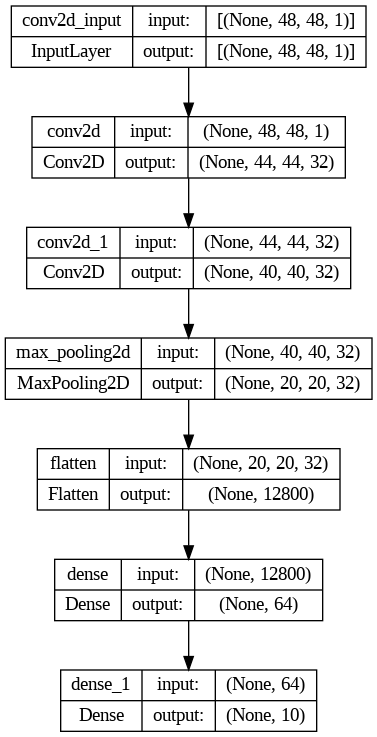

In [ ]:
from tensorflow import keras

best_params = {'dense_units': 64,'kernel': (5, 5),'learning_rate': 0.001,'strides': (1, 1)}

best_model = create_cnn_ex2(**best_params)
keras.utils.plot_model(best_model , show_shapes=True)

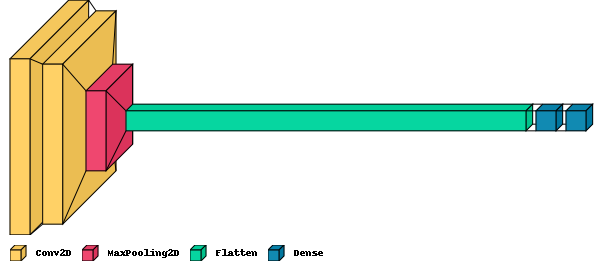

In [ ]:
import visualkeras

visualkeras.layered_view(best_model , legend=True)

In [ ]:

best_params = {'dense_units': 64,'kernel': (5, 5),'learning_rate': 0.001,'strides': (1, 1)}

C:\Users\Poornima\AppData\Local\Temp\ipykernel_6376\2466078748.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=create_cnn_ex2, **best_params)


31/31 [==============================] - 1s 43ms/step


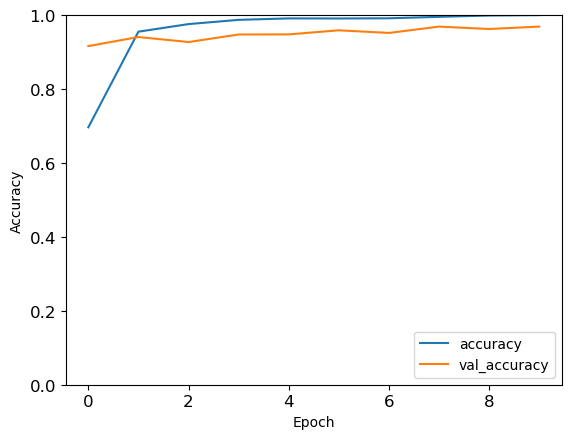

In [ ]:

model = KerasClassifier(build_fn=create_cnn_ex2, **best_params)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,model,
                                                  'M3 Best 0.001',epochs=epochs,batch_size=batch_size)
plotHistory(history)

In [ ]:
results_df

,Model,CV10_Mean_Accuracy,Train_accuracy,Test_accuracy
0,M1 LR 0.1,0.231785,0.229102,0.233010
1,M1 LR 0.001,0.597214,0.963364,0.881230
2,M1 LR 0.0001,0.388958,0.728483,0.623948
3,M1 LR 0.00001,0.256863,0.351909,0.341748
4,M2 LR 0.001,0.378328,0.934469,0.848220
5,M3 LR 0.001 softmax,0.625077,0.986275,0.906149
6,M3 LR 0.001 sigmoid,0.630134,0.921672,0.872816
7,M3 LR 0.001 linear,0.222910,0.253870,0.256634
8,M3 Best 0.001,0.934572,1.000000,0.968932


In [ ]:
results_df.to_csv("results_df_final", sep=',', index=False, encoding='utf-8')

#### Adding layers to the best model:

In [ ]:
def create_cnn_ex2_added_layers(input_shape=input_shape, num_classes=10, dense_units=64,
                    learning_rate=0.001, loss='sparse_categorical_crossentropy',
                    kernel=(3, 3), strides=(2, 2), filters=32, metrics=['accuracy'],):
    model = models.Sequential()
    # convolutional input layer
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(filters, kernel, activation='relu', input_shape=input_shape, strides=strides))
    model.add(layers.Conv2D(filters, kernel, activation='relu',  strides=strides))
    model.add(layers.MaxPooling2D((2, 2)))

    # convolutional layer
    model.add(layers.Flatten())
    # fully connected layer
    model.add(layers.Dense(dense_units, activation='relu'))
    # fully connected output layer
    model.add(layers.Dense(num_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model


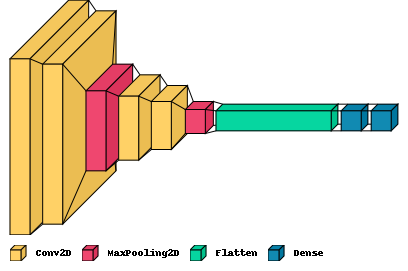

In [ ]:
import visualkeras
visualkeras.layered_view( create_cnn_ex2_added_layers(**best_params), legend=True)


C:\Users\Poornima\AppData\Local\Temp\ipykernel_6376\1551632283.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  layers_added_best_model = KerasClassifier(build_fn=create_cnn_ex2_added_layers, **best_params)


31/31 [==============================] - 2s 47ms/step


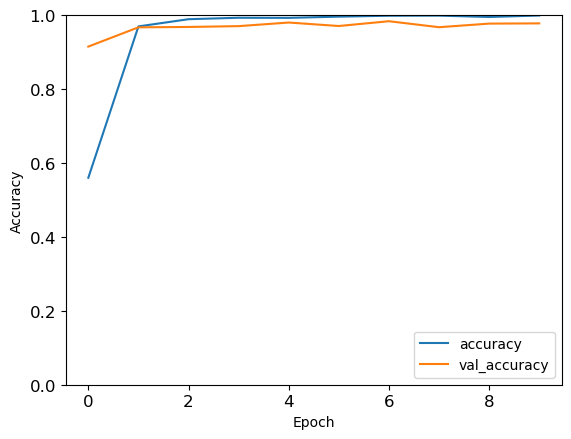

In [ ]:
layers_added_best_model = KerasClassifier(build_fn=create_cnn_ex2_added_layers, **best_params)
results_dict, history=cross_validate_and_evaluate(x_train_reshaped, y_train,
                                                  x_test_reshaped, y_test,layers_added_best_model,
                                                  'M3 Best 0.001 Added layers',epochs=epochs,batch_size=batch_size)
plotHistory(history)

In [ ]:
y_pred = layers_added_best_model.predict(x_test_reshaped)

df = calculate_metrics_and_mean(x_test_reshaped, y_test, y_pred, model)


 1/97 [..............................] - ETA: 6s

10/10 [==============================] - 1s 43ms/step - loss: 0.6089 - accuracy: 0.8382


In [ ]:
df

,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,AUC,accuracy,CV mean,CV std
0,0.951613,0.983333,0.967213,0.983333,0.000990,0.999010,0.983333,0.998460,0.97767,0.757282,0.091569
1,0.955882,0.993056,0.974114,0.993056,0.013924,0.986076,0.993056,0.997122,NaN,NaN,NaN
2,0.979030,0.996000,0.987442,0.996000,0.006838,0.993162,0.996000,0.999032,NaN,NaN,NaN
3,0.993348,0.995556,0.994451,0.995556,0.001136,0.998864,0.995556,0.999806,NaN,NaN,NaN
4,1.000000,0.960606,0.979907,0.960606,0.000000,1.000000,0.960606,0.998162,NaN,NaN,NaN
5,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN
6,0.909091,1.000000,0.952381,1.000000,0.003000,0.997000,1.000000,0.999393,NaN,NaN,NaN
7,1.000000,0.500000,0.666667,0.500000,0.000000,1.000000,0.500000,0.999967,NaN,NaN,NaN
8,0.986667,0.986667,0.986667,0.986667,0.000680,0.999320,0.986667,0.998687,NaN,NaN,NaN
9,0.967742,1.000000,0.983607,1.000000,0.001000,0.999000,1.000000,0.999985,NaN,NaN,NaN


<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

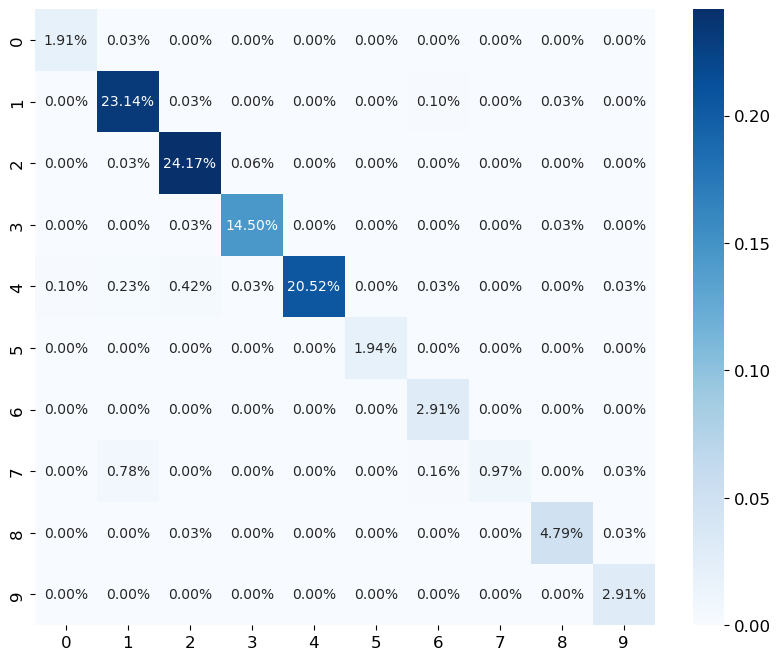

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix_train = confusion_matrix(y_test,y_pred )
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_train/np.sum(confusion_matrix_train), annot=True,  fmt='.2%', cmap='Blues')
plt.tight_layout

In [ ]:
results_df

,Model,CV10_Mean_Accuracy,Train_accuracy,Test_accuracy
0,M1 LR 0.1,0.231785,0.229102,0.233010
1,M1 LR 0.001,0.597214,0.963364,0.881230
2,M1 LR 0.0001,0.388958,0.728483,0.623948
3,M1 LR 0.00001,0.256863,0.351909,0.341748
4,M2 LR 0.001,0.378328,0.934469,0.848220
5,M3 LR 0.001 softmax,0.625077,0.986275,0.906149
6,M3 LR 0.001 sigmoid,0.630134,0.921672,0.872816
7,M3 LR 0.001 linear,0.222910,0.253870,0.256634
8,M3 Best 0.001,0.934572,1.000000,0.968932
9,M3 Best 0.001 Added layers,0.947678,0.999794,0.977670


### Comparing Accuracy of all models

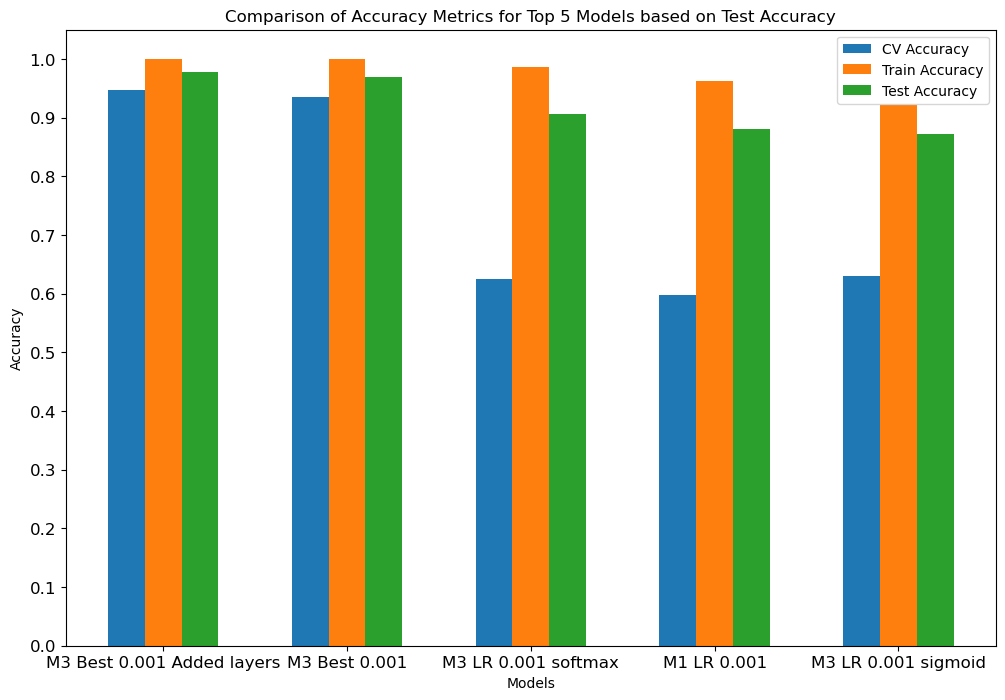

In [ ]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 8))

# Sorting results dataframe such that test accuracy is high to low
sorted_results = results_df.sort_values(by='Test_accuracy', ascending=False)

top_5_results = sorted_results.head(5)


models = top_5_results['Model']
cv_accuracy = top_5_results['CV10_Mean_Accuracy']
train_accuracy = top_5_results['Train_accuracy']
test_accuracy = top_5_results['Test_accuracy']


bar_width = 0.2
index = range(len(models))

plt.bar(index, cv_accuracy, width=bar_width, label='CV Accuracy')
plt.bar([i + bar_width for i in index], train_accuracy, width=bar_width, label='Train Accuracy')
plt.bar([i + 2 * bar_width for i in index], test_accuracy, width=bar_width, label='Test Accuracy')

plt.yticks([i/10 for i in range(11)])

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Accuracy Metrics for Top 5 Models based on Test Accuracy')
plt.xticks([i + bar_width for i in index], models)
plt.legend()

plt.show()

### Visualizing CNN

In [ ]:
keras_model = layers_added_best_model.model
keras_model.summary()

Model: "sequential_124"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_206 (Conv2D)         (None, 44, 44, 32)        832       
                                                                 
 conv2d_207 (Conv2D)         (None, 40, 40, 32)        25632     
                                                                 
 max_pooling2d_136 (MaxPooli  (None, 20, 20, 32)       0         
 ng2D)                                                           
                                                                 
 conv2d_208 (Conv2D)         (None, 16, 16, 32)        25632     
                                                                 
 conv2d_209 (Conv2D)         (None, 12, 12, 32)        25632     
                                                                 
 max_pooling2d_137 (MaxPooli  (None, 6, 6, 32)         0         
 ng2D)                                              

#### Visualizing filters

Reference: https://github.com/dudeperf3ct/DL_Notebooks/blob/master/Vis%20CNN/vis_cnn_keras.ipynb

(5, 5, 32, 32) -0.2800819 0.18579265


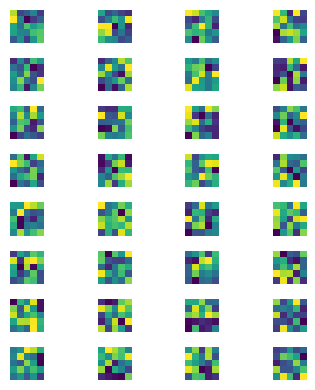

In [ ]:
import math
import matplotlib.pyplot as plt
import numpy as np

def display_filters(model, layer_name, cols=5, interpolation=None):

    layer = model.get_layer(layer_name)
    weights = layer.get_weights()[0]
    print(weights.shape, weights.min(), weights.max())


    rows = math.ceil(weights.shape[3] / cols)
    plt.figure(figsize=(4,4))

    i = 1
    for j in range(weights.shape[3]):
        plt.subplot(rows, cols, i)
        plt.axis("off")
        # Display each filter
        plt.imshow(weights[:, :, 0, j], interpolation=interpolation)
        i += 1
    plt.tight_layout()
    plt.show()


layer_name = 'conv2d_209'
display_filters(layers_added_best_model.model, layer_name, cols=4 , interpolation="None")




### Running the best model on randomized images

97/97 [==============================] - 2s 25ms/step
Overall Test Accuracy: 0.9692556634304207


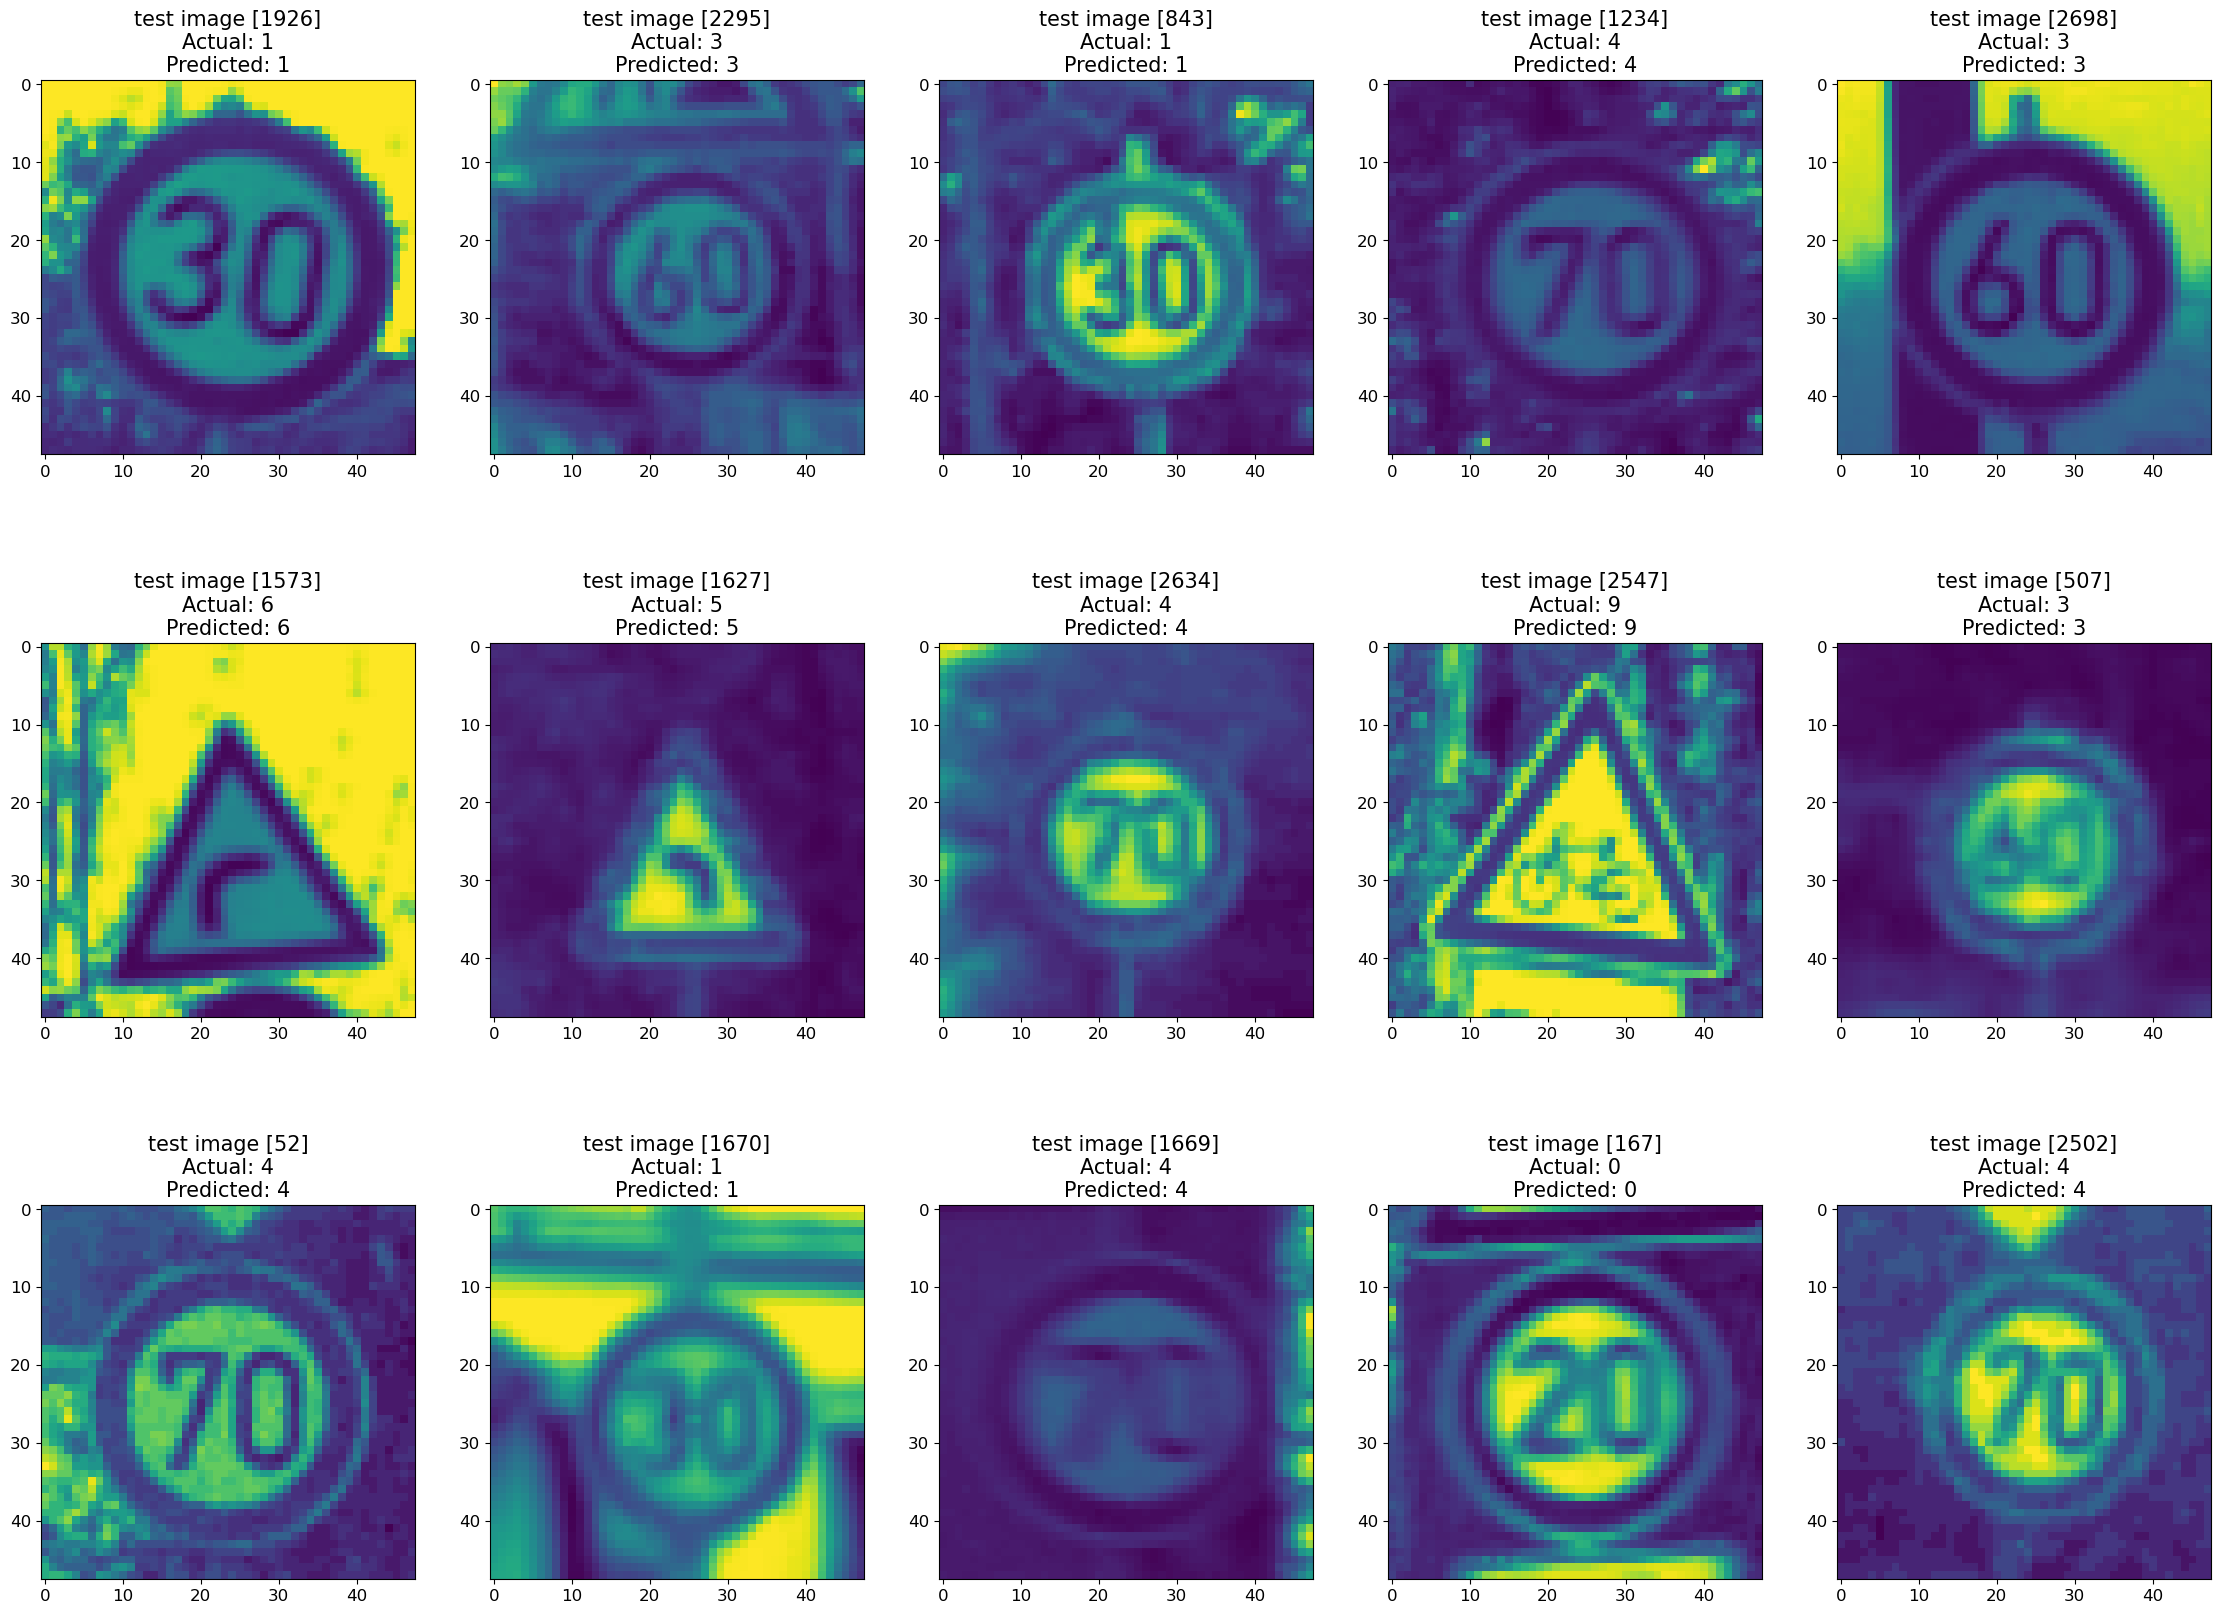

In [ ]:
# Done 15 random images on the Test Dataset
import matplotlib.pyplot as plt
import numpy as np
import random
from sklearn.metrics import accuracy_score


def show_images_with_predictions(images, actual_values, predicted_values, title_texts):
    cols = 5
    rows = int(len(images) / cols) + 1
    plt.figure(figsize=(28, 28))
    index = 1

    for x in zip(images, actual_values, predicted_values, title_texts):
        image = x[0]
        actual_value = x[1]
        predicted_value = x[2]
        title_text = x[3]
        plt.subplot(rows, cols, index)


        height, width = int(np.sqrt(len(image))), int(np.sqrt(len(image)))
        image = image.reshape((height, width))

        plt.imshow(image)

        # Text showing actual and predicted value
        title_text += f'\nActual: {actual_value}\nPredicted: {predicted_value}'

        if (title_text != ''):
            plt.title(title_text, fontsize=15)
        index += 1


random_images = []
predicted_values = layers_added_best_model.predict(x_test_reshaped)
actual_values = y_test

for i in range(0, 15):
    r = random.randint(0, len(x_test) - 1)
    random_images.append((x_test.iloc[r].values, actual_values.iloc[r,0], predicted_values[r], 'test image [' + str(r) + ']'))

show_images_with_predictions(list(map(lambda x: x[0], random_images)),
                              list(map(lambda x: x[1], random_images)),
                              list(map(lambda x: x[2], random_images)),
                              list(map(lambda x: x[3], random_images)))

# Calculate overall accuracy
test_accuracy = accuracy_score(actual_values, predicted_values)
print(f"Overall Test Accuracy: {test_accuracy}")

## Additional Exploration

### Existing CNN Architectures

In [9]:
x_train_array = np.array(x_train)
x_train_reshaped = x_train_array.reshape(-1, 48, 48, 1)
x_train_reshaped = np.repeat(x_train_reshaped, 3, axis=-1)

x_test_array = np.array(x_test)
x_test_reshaped = x_test_array.reshape(-1, 48, 48, 1)
x_test_reshaped = np.repeat(x_test_reshaped, 3, axis=-1)

In [10]:
import pandas as pd
from sklearn.metrics import accuracy_score

overall_metrics = pd.DataFrame()

def performance_display(x_train, y_train, y_pred_train, x_test, y_test, y_pred, model, model_name):
    global overall_metrics

    metrics_df = calculate_metrics_and_mean(x_test_reshaped, y_test, y_pred, model)
    drop_labels = ["AUC", "CV mean", "CV std"]
    metrics_df = metrics_df.drop(columns=drop_labels)
    last_row = metrics_df.tail(1)
    last_row.insert(0, "Name", model_name, True)
    train_accuracy = accuracy_score(y_train, y_pred_train)
    last_row_copy = last_row.copy()
    last_row_copy.loc[:, "train accuracy"] = train_accuracy
    last_row_copy.reset_index(drop=True, inplace=True)


    result_dict = {"train accuracy": train_accuracy}
    result_df = pd.DataFrame(result_dict, index=[0])

    overall_metrics = pd.concat([overall_metrics, last_row_copy], ignore_index=True)

    return overall_metrics


#### a) VGG16: CNN used for image recognition


In [11]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.applications import VGG16

import numpy as np
from sklearn.metrics import accuracy_score

In [12]:
epochs=10

In [13]:
vgg16_model = Sequential()
vgg16_model.add(VGG16(weights='imagenet', include_top=False, input_shape=(48,48,3)))
vgg16_model.add(Flatten())
vgg16_model.add(Dense(1024, activation='relu'))
vgg16_model.add(Dense(10, activation='softmax'))

58889256/58889256 [==============================] - 0s 0us/step


In [14]:
vgg16_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
vgg16_model.fit(x_train_reshaped, y_train, epochs=epochs, validation_data=(x_test_reshaped, y_test))

Epoch 1/10
303/303 [==============================] - 30s 51ms/step - loss: 2.2731 - accuracy: 0.3026 - val_loss: 1.5262 - val_accuracy: 0.3955
Epoch 2/10
303/303 [==============================] - 14s 47ms/step - loss: 0.8830 - accuracy: 0.6704 - val_loss: 0.7358 - val_accuracy: 0.7841
Epoch 3/10
303/303 [==============================] - 13s 44ms/step - loss: 0.2346 - accuracy: 0.9226 - val_loss: 0.3652 - val_accuracy: 0.8981
Epoch 4/10
303/303 [==============================] - 13s 43ms/step - loss: 0.1026 - accuracy: 0.9704 - val_loss: 0.1724 - val_accuracy: 0.9612
Epoch 5/10
303/303 [==============================] - 13s 43ms/step - loss: 0.1509 - accuracy: 0.9608 - val_loss: 0.1552 - val_accuracy: 0.9508
Epoch 6/10
303/303 [==============================] - 13s 43ms/step - loss: 0.0545 - accuracy: 0.9854 - val_loss: 0.0966 - val_accuracy: 0.9780
Epoch 7/10
303/303 [==============================] - 13s 44ms/step - loss: 0.1876 - accuracy: 0.9514 - val_loss: 0.3707 - val_accuracy:

In [16]:
y_pred_prob = vgg16_model.predict(x_test_reshaped)
y_pred = np.argmax(y_pred_prob, axis=1)

97/97 [==============================] - 1s 12ms/step


In [17]:
y_pred_prob_train = vgg16_model.predict(x_train_reshaped)
y_pred_train = np.argmax(y_pred_prob_train, axis=1)

303/303 [==============================] - 3s 11ms/step


In [18]:
train_accuracy = accuracy_score(y_train,y_pred_train)
train_accuracy

0.9963880288957688

In [21]:
performance_display(x_train_reshaped,y_train,y_pred_train,x_test_reshaped, y_test, y_pred, vgg16_model, "VGG16")

,Name,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,accuracy,train accuracy
0,VGG16,0.948911,0.944241,0.938971,0.944241,0.002312,0.997688,0.944241,0.978964,0.996388


#### b) MobileNetV2


In [22]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

mobilenetv2_model = Sequential()
mobilenetv2_model.add(MobileNetV2(weights='imagenet', include_top=False, input_shape=(48, 48, 3)))
mobilenetv2_model.add(GlobalAveragePooling2D())
mobilenetv2_model.add(Dense(1024, activation='relu'))
mobilenetv2_model.add(Dense(10, activation='softmax'))

9406464/9406464 [==============================] - 0s 0us/step


In [23]:
mobilenetv2_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [25]:
mobilenetv2_model.fit(x_train_reshaped, y_train, epochs=epochs, validation_data=(x_test_reshaped, y_test))

Epoch 1/10
303/303 [==============================] - 11s 35ms/step - loss: 0.0713 - accuracy: 0.9805 - val_loss: 3.5448 - val_accuracy: 0.8256
Epoch 2/10
303/303 [==============================] - 11s 35ms/step - loss: 0.0407 - accuracy: 0.9899 - val_loss: 5.0736 - val_accuracy: 0.7599
Epoch 3/10
303/303 [==============================] - 11s 37ms/step - loss: 0.0575 - accuracy: 0.9876 - val_loss: 3.9386 - val_accuracy: 0.8016
Epoch 4/10
303/303 [==============================] - 10s 33ms/step - loss: 0.0206 - accuracy: 0.9944 - val_loss: 0.3700 - val_accuracy: 0.9579
Epoch 5/10
303/303 [==============================] - 10s 33ms/step - loss: 0.0270 - accuracy: 0.9934 - val_loss: 0.2517 - val_accuracy: 0.9806
Epoch 6/10
303/303 [==============================] - 12s 38ms/step - loss: 0.0513 - accuracy: 0.9884 - val_loss: 0.6525 - val_accuracy: 0.9317
Epoch 7/10
303/303 [==============================] - 10s 35ms/step - loss: 0.0382 - accuracy: 0.9906 - val_loss: 0.2512 - val_accuracy:

In [26]:
y_pred_prob = mobilenetv2_model.predict(x_test_reshaped)
y_pred = np.argmax(y_pred_prob, axis=1)

97/97 [==============================] - 1s 7ms/step


In [27]:
y_pred_prob_train = mobilenetv2_model.predict(x_train_reshaped)
y_pred_train = np.argmax(y_pred_prob_train, axis=1)

303/303 [==============================] - 3s 8ms/step


In [28]:
performance_display(x_train_reshaped,y_train,y_pred_train,x_test_reshaped, y_test, y_pred, mobilenetv2_model, "MobileNetV2")

,Name,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,accuracy,train accuracy
0,VGG16,0.948911,0.944241,0.938971,0.944241,0.002312,0.997688,0.944241,0.978964,0.996388
1,MobileNetV2,0.600552,0.531824,0.511196,0.531824,0.036318,0.963682,0.531824,0.720388,0.697420


#### c) DenseNet121

In [29]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

densenet_model = Sequential()
densenet_model.add(DenseNet121(weights='imagenet', include_top=False, input_shape=(48, 48, 3)))
densenet_model.add(GlobalAveragePooling2D())
densenet_model.add(Dense(1024, activation='relu'))
densenet_model.add(Dense(10, activation='softmax'))

29084464/29084464 [==============================] - 0s 0us/step


In [30]:
densenet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
densenet_model.fit(x_train_reshaped, y_train, epochs=epochs, validation_data=(x_test_reshaped, y_test))

Epoch 1/10
303/303 [==============================] - 95s 104ms/step - loss: 0.4027 - accuracy: 0.8804 - val_loss: 0.5268 - val_accuracy: 0.8929
Epoch 2/10
303/303 [==============================] - 25s 84ms/step - loss: 0.0494 - accuracy: 0.9862 - val_loss: 0.1292 - val_accuracy: 0.9608
Epoch 3/10
303/303 [==============================] - 27s 88ms/step - loss: 0.0485 - accuracy: 0.9874 - val_loss: 0.1704 - val_accuracy: 0.9650
Epoch 4/10
303/303 [==============================] - 27s 88ms/step - loss: 0.0314 - accuracy: 0.9917 - val_loss: 0.1710 - val_accuracy: 0.9589
Epoch 5/10
303/303 [==============================] - 26s 87ms/step - loss: 0.0434 - accuracy: 0.9888 - val_loss: 0.0477 - val_accuracy: 0.9838
Epoch 6/10
303/303 [==============================] - 26s 85ms/step - loss: 0.1342 - accuracy: 0.9719 - val_loss: 75397.3984 - val_accuracy: 0.2136
Epoch 7/10
303/303 [==============================] - 27s 89ms/step - loss: 0.1342 - accuracy: 0.9578 - val_loss: 0.0644 - val_accu

In [32]:
y_pred_prob = densenet_model.predict(x_test_reshaped)
y_pred = np.argmax(y_pred_prob, axis=1)

97/97 [==============================] - 3s 13ms/step


In [33]:
y_pred_prob_train = densenet_model.predict(x_train_reshaped)
y_pred_train = np.argmax(y_pred_prob_train, axis=1)

303/303 [==============================] - 5s 18ms/step


In [34]:
performance_display(x_train_reshaped,y_train,y_pred_train,x_test_reshaped, y_test, y_pred,densenet_model , "DenseNet121")

,Name,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,accuracy,train accuracy
0,VGG16,0.948911,0.944241,0.938971,0.944241,0.002312,0.997688,0.944241,0.978964,0.996388
1,MobileNetV2,0.600552,0.531824,0.511196,0.531824,0.036318,0.963682,0.531824,0.720388,0.697420
2,DenseNet121,0.931175,0.938548,0.927067,0.938548,0.002540,0.997460,0.938548,0.976375,0.995046


#### d) ResNet50

In [35]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

resnet_model = Sequential()
resnet_model.add(ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3)))
resnet_model.add(GlobalAveragePooling2D())
resnet_model.add(Dense(1024, activation='relu'))
resnet_model.add(Dense(10, activation='softmax'))

94765736/94765736 [==============================] - 0s 0us/step


In [36]:
resnet_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
resnet_model.fit(x_train_reshaped, y_train, epochs=epochs, validation_data=(x_test_reshaped, y_test))

Epoch 1/10
303/303 [==============================] - 53s 68ms/step - loss: 0.4128 - accuracy: 0.8841 - val_loss: 0.1965 - val_accuracy: 0.9489
Epoch 2/10
303/303 [==============================] - 18s 60ms/step - loss: 0.0768 - accuracy: 0.9800 - val_loss: 0.2945 - val_accuracy: 0.9472
Epoch 3/10
303/303 [==============================] - 17s 55ms/step - loss: 0.0596 - accuracy: 0.9846 - val_loss: 0.0733 - val_accuracy: 0.9803
Epoch 4/10
303/303 [==============================] - 17s 56ms/step - loss: 0.0435 - accuracy: 0.9879 - val_loss: 0.1407 - val_accuracy: 0.9683
Epoch 5/10
303/303 [==============================] - 17s 55ms/step - loss: 0.0370 - accuracy: 0.9898 - val_loss: 0.0871 - val_accuracy: 0.9754
Epoch 6/10
303/303 [==============================] - 17s 56ms/step - loss: 0.0793 - accuracy: 0.9798 - val_loss: 0.4444 - val_accuracy: 0.8748
Epoch 7/10
303/303 [==============================] - 17s 56ms/step - loss: 0.0511 - accuracy: 0.9873 - val_loss: 0.0965 - val_accuracy:

In [38]:
y_pred_prob = resnet_model.predict(x_test_reshaped)
y_pred = np.argmax(y_pred_prob, axis=1)

97/97 [==============================] - 2s 14ms/step


In [39]:
y_pred_prob_train = resnet_model.predict(x_train_reshaped)
y_pred_train = np.argmax(y_pred_prob_train, axis=1)

303/303 [==============================] - 4s 13ms/step


In [40]:
performance_display(x_train_reshaped,y_train,y_pred_train,x_test_reshaped, y_test, y_pred, resnet_model, "ResNet50")

,Name,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,accuracy,train accuracy
0,VGG16,0.948911,0.944241,0.938971,0.944241,0.002312,0.997688,0.944241,0.978964,0.996388
1,MobileNetV2,0.600552,0.531824,0.511196,0.531824,0.036318,0.963682,0.531824,0.720388,0.697420
2,DenseNet121,0.931175,0.938548,0.927067,0.938548,0.002540,0.997460,0.938548,0.976375,0.995046
3,ResNet50,0.988517,0.978464,0.982959,0.978464,0.001794,0.998206,0.978464,0.985761,0.994118


### Comparing performances

In [41]:
overall_metrics

,Name,precision,recall,f1-score,TPR,FPR,specificity,sensitivity,accuracy,train accuracy
0,VGG16,0.948911,0.944241,0.938971,0.944241,0.002312,0.997688,0.944241,0.978964,0.996388
1,MobileNetV2,0.600552,0.531824,0.511196,0.531824,0.036318,0.963682,0.531824,0.720388,0.697420
2,DenseNet121,0.931175,0.938548,0.927067,0.938548,0.002540,0.997460,0.938548,0.976375,0.995046
3,ResNet50,0.988517,0.978464,0.982959,0.978464,0.001794,0.998206,0.978464,0.985761,0.994118
